## Nguyễn Thành Danh - Differential Evolution (DE) & (1+λ)-Evolution Strategies (ES)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# 240201008
STUDENT_ID = 1008

### Objective Functions

In [ ]:
def sphere(z):
    """Sphere function: f(z) = sum(z_i^2). Accepts lists or numpy arrays."""
    z = np.asarray(z)
    return float(np.sum(z**2))


In [ ]:
def ackley(z, a=20, b=0.2, c=2*np.pi):
    z = np.asarray(z)
    n = z.size

    sum1 = np.mean(z**2)
    sum2 = np.mean(np.cos(c * z))

    term1 = -a * np.exp(-b * np.sqrt(sum1))
    term2 = -np.exp(sum2)
    return float(term1 + term2 + a + np.e)

In [ ]:
def griewank(z):
    z = np.asarray(z)
    sum_ = np.sum(z**2) / 4000.0
    idx = np.arange(1, z.size + 1)
    prod_ = np.prod(np.cos(z / np.sqrt(idx)))
    return float(1.0 + sum_ - prod_)

In [295]:
def rosenbrock(z):
    sum_ = 0
    for i in range(len(z) - 1):
        xi = z[i]
        xi_next = z[i + 1]
        sum_ += 100 * (xi_next - xi**2)**2 + (xi - 1) ** 2
    return sum_

In [296]:
def michalewicz(z, m=10):
    sum_ = 0
    for i, x in enumerate(z):
        sum_ += np.sin(x) * np.sin(((i + 1) * x**2) / np.pi) ** (2 * m)
    return -sum_

### Differential Evolution (DE)

In [297]:
def de(fobj, bounds, F_scale=0.8, cross_prob=0.7, popsize=20, max_evals=2000):
    dimensions = len(bounds); lower_bound, upper_bound = np.asarray(bounds).T

    diff = np.fabs(lower_bound - upper_bound)

    pop = lower_bound + diff * np.random.rand(popsize, dimensions)

    fitness = np.asarray([fobj(ind) for ind in pop])
    eval_count = popsize
    should_break = False

    best_idx = np.argmin(fitness)

    best = pop[best_idx]

    results = []; all_pops = []
    results.append((np.copy(best), fitness[best_idx]))
    all_pops.append(np.copy(pop))
    while eval_count < max_evals:
        for j in range(popsize):
            if eval_count >= max_evals:
                should_break = True
                break

            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + F_scale * (b-c), lower_bound, upper_bound)

            cross_points = np.random.rand(dimensions) < cross_prob
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True

            trial = np.where(cross_points, mutant, pop[j])

            f = fobj(trial)
            eval_count += 1

            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial

        if should_break:
            break
        results.append((np.copy(best), fitness[best_idx]))
        all_pops.append(np.copy(pop))


    return results, all_pops


### Differential Evolution (DE)

In [298]:
def es(fobj, bounds, sigma_init=1.0, c_inc=1.1, c_dec=0.6, popsize=20, max_evals=2000):
    dimensions = len(bounds)

    lower_bound, upper_bound = np.asarray(bounds).T

    diff = np.fabs(lower_bound - upper_bound)

    mu = lower_bound + diff * np.random.rand(dimensions)

    mu_fitness = fobj(mu)
    eval_count = 1
    should_break = False

    results = []
    all_pops = []
    results.append((np.copy(mu), mu_fitness))
    sigma = sigma_init

    while eval_count < max_evals:
        epsilon = np.random.randn(popsize, dimensions)
        offspring = mu + sigma * epsilon
        offspring = np.clip(offspring, lower_bound, upper_bound)
        offspring_fitness = []
        for i in range(popsize):
            if eval_count >= max_evals:
                should_break = True
                break
            fitness = fobj(offspring[i])
            offspring_fitness.append(fitness)
            eval_count += 1
            
        if should_break:
            break
            
        offspring_fitness = np.array(offspring_fitness)
        best_idx = offspring_fitness.argmin()
        best_fitness = offspring_fitness[best_idx]
        best_offspring = offspring[best_idx]

        if best_fitness <= mu_fitness:
            mu = best_offspring.copy()
            mu_fitness = best_fitness
            sigma *= c_inc
        else:
            sigma *= c_dec

        results.append((np.copy(mu), mu_fitness))
        all_pops.append(np.copy(offspring))

    return results, all_pops

### Factory Functions

In [299]:
def get_bounds(func_name, dim):
    bounds_dict = {
        'sphere': [(-5.12, 5.12)] * dim,
        'ackley': [(-32.768, 32.768)] * dim,
        'griewank': [(-600, 600)] * dim,
        'rosenbrock': [(-5, 10)] * dim,
        'michalewicz': [(0, np.pi)] * dim
    }
    
    return bounds_dict[func_name]

def get_function(func_name):
    func_dict = {
        'sphere': sphere,
        'ackley': ackley,
        'griewank': griewank,
        'rosenbrock': rosenbrock,
        'michalewicz': michalewicz
    }
    
    return func_dict[func_name]

def run_experiment(func_name, dim, algorithm):
    func = get_function(func_name)
    bounds = get_bounds(func_name, dim)
    popsize = 10 if dim == 2 else 100
    max_evals = 2000 if dim == 2 else 20000
    max_iters = max_evals // popsize

    seeds = list(range(STUDENT_ID, STUDENT_ID + 10))
    all_results = []
    for seed in seeds:
        np.random.seed(seed)
        
        if algorithm == 'DE':
            results, all_pops = de(func, bounds=bounds, popsize=popsize, max_evals=max_evals)
        else:
            results, all_pops = es(func, bounds=bounds, popsize=popsize, max_evals=max_evals)
        
        fitness_per_gen = [result[1] for result in results]
        all_results.append(fitness_per_gen)
    
    return all_results

def plot_and_analyze(func_name, dim):
    print("Running...")
    de_results = run_experiment(func_name, dim, 'DE')
    es_results = run_experiment(func_name, dim, 'ES')
    
    de_mean = np.mean(de_results, axis=0)
    de_std = np.std(de_results, axis=0)
    es_mean = np.mean(es_results, axis=0)
    es_std = np.std(es_results, axis=0)
    
    # Create generations axis
    generations = range(len(de_mean))
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    plt.plot(generations, de_mean, 'b-', label='DE', linewidth=2)
    plt.fill_between(generations, de_mean - de_std, de_mean + de_std, 
                     alpha=0.2, color='blue')
    plt.plot(generations, es_mean, 'r-', label='ES', linewidth=2)
    plt.fill_between(generations, es_mean - es_std, es_mean + es_std, 
                     alpha=0.2, color='red')
    
    # Formatting
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title(f'{func_name.title()} Function (d={dim})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if func_name in ['sphere', 'ackley', 'griewank', 'rosenbrock']:
        plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # ===== SUMMARY TABLE =====
    # Get final fitness values (last generation)
    de_final = [run[-1] for run in de_results]
    es_final = [run[-1] for run in es_results]
    
    # Calculate final statistics
    de_final_mean = np.mean(de_final)
    de_final_std = np.std(de_final)
    es_final_mean = np.mean(es_final)
    es_final_std = np.std(es_final)
    
    return {
        'function': func_name,
        'dimension': dim,
        'DE_mean': de_final_mean,
        'DE_std': de_final_std,
        'ES_mean': es_final_mean,
        'ES_std': es_final_std,
        'de_results': de_results,
        'es_results': es_results
    }

def run_all_experiments():
    """Run all experiments efficiently - once per function/dimension"""
    
    functions = ['sphere', 'ackley', 'griewank', 'rosenbrock', 'michalewicz']
    dimensions = [2, 10]
    
    all_summaries = []
    
    for func in functions:
        for dim in dimensions:
            summary = plot_and_analyze(func, dim)
            all_summaries.append(summary)
    
    # Create final comparison table
    print("\n" + "="*70)
    print("FINAL COMPARISON TABLE")
    print("="*70)
    print(f"{'Function':<12} {'Dim':<4} {'DE Mean':<12} {'DE Std':<12} {'ES Mean':<12} {'ES Std':<12} {'Winner':<8}")
    print("-"*70)
    
    for summary in all_summaries:
        # Determine winner based on mean fitness (lower is better)
        if summary['DE_mean'] < summary['ES_mean']:
            winner = "DE"
        elif summary['ES_mean'] < summary['DE_mean']:
            winner = "ES"
        else:
            winner = "Tie"
        
        print(f"{summary['function']:<12} {summary['dimension']:<4} "
              f"{summary['DE_mean']:<12.7f} {summary['DE_std']:<12.7f} "
              f"{summary['ES_mean']:<12.7f} {summary['ES_std']:<12.7f} "
              f"{winner:<8}")
    
    return all_summaries

Running...


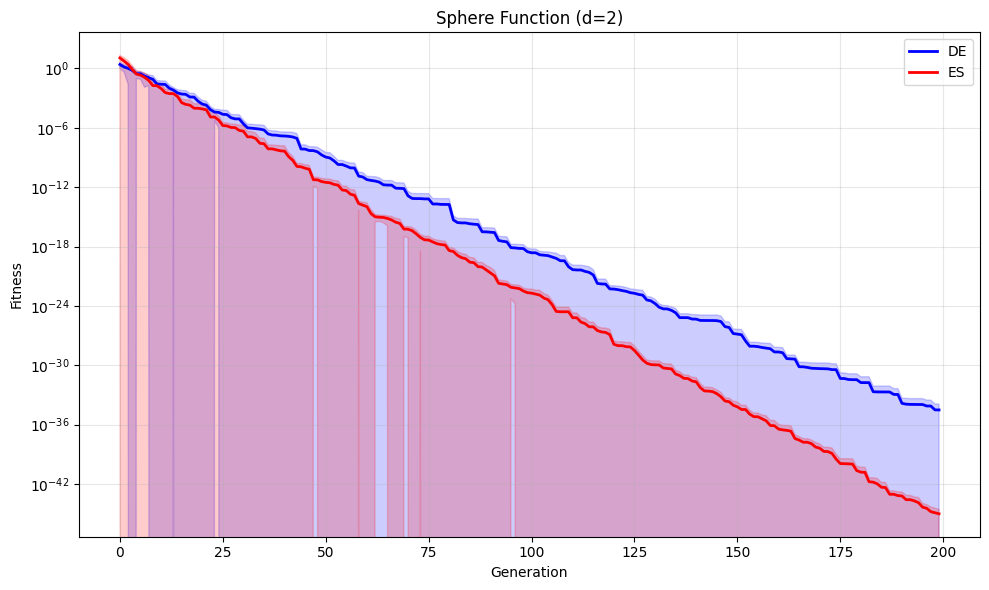

Running...


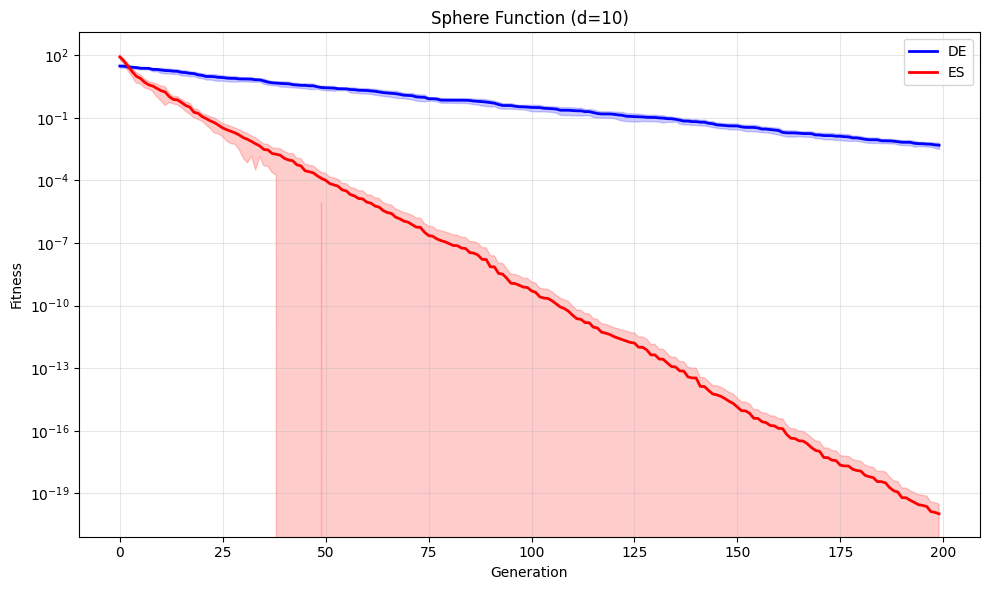

Running...


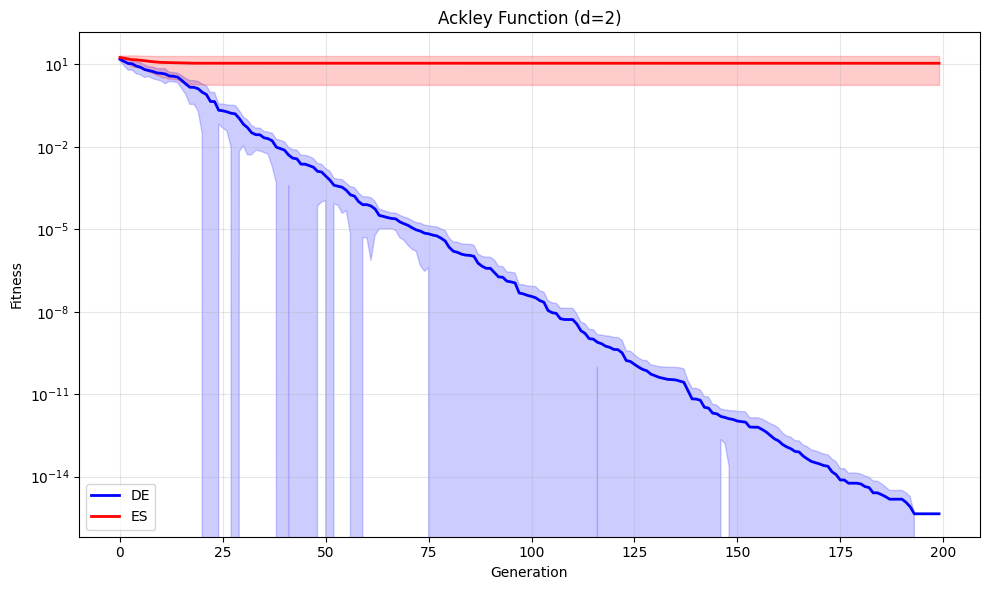

Running...


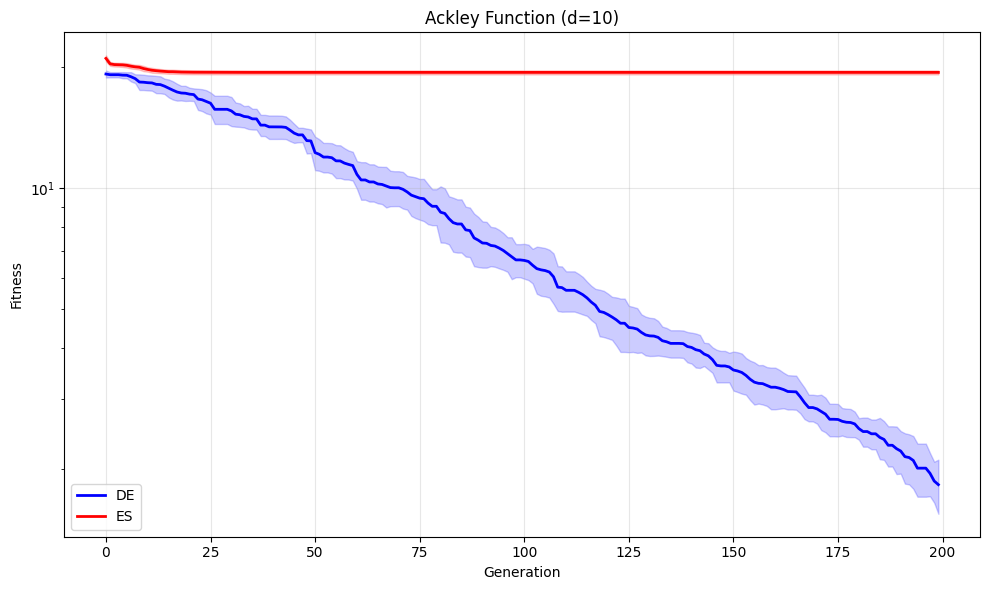

Running...


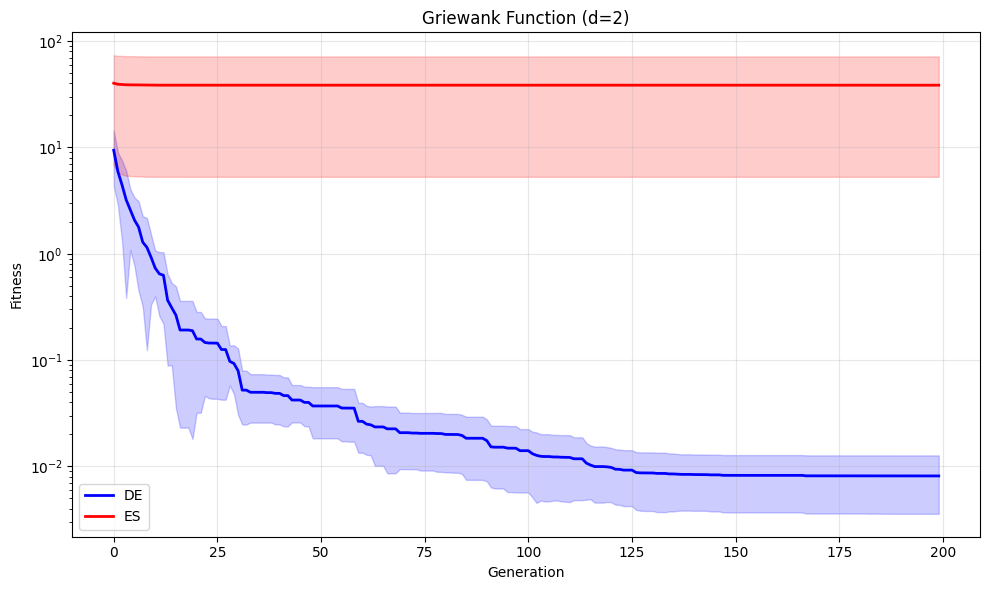

Running...


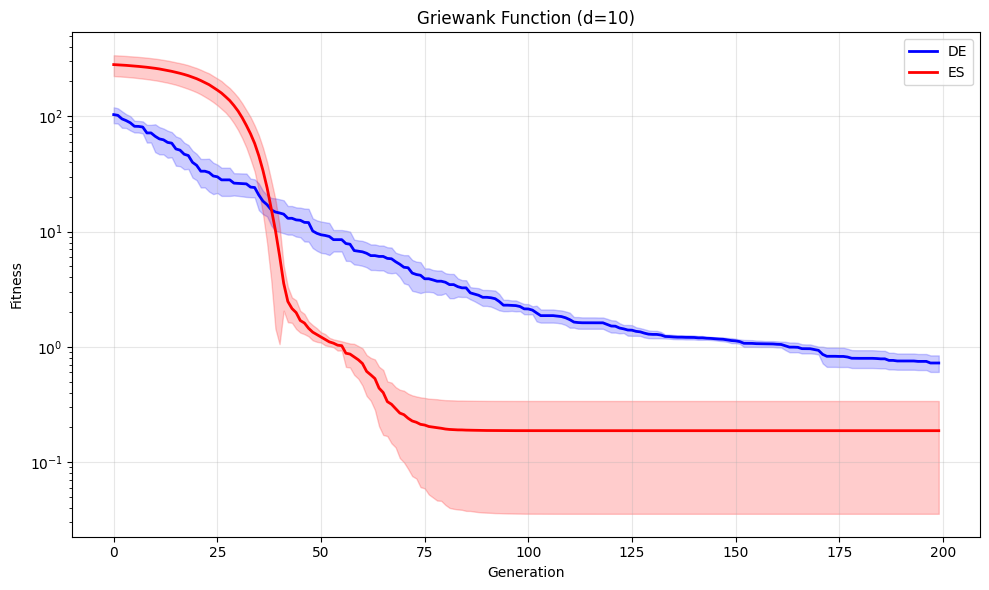

Running...


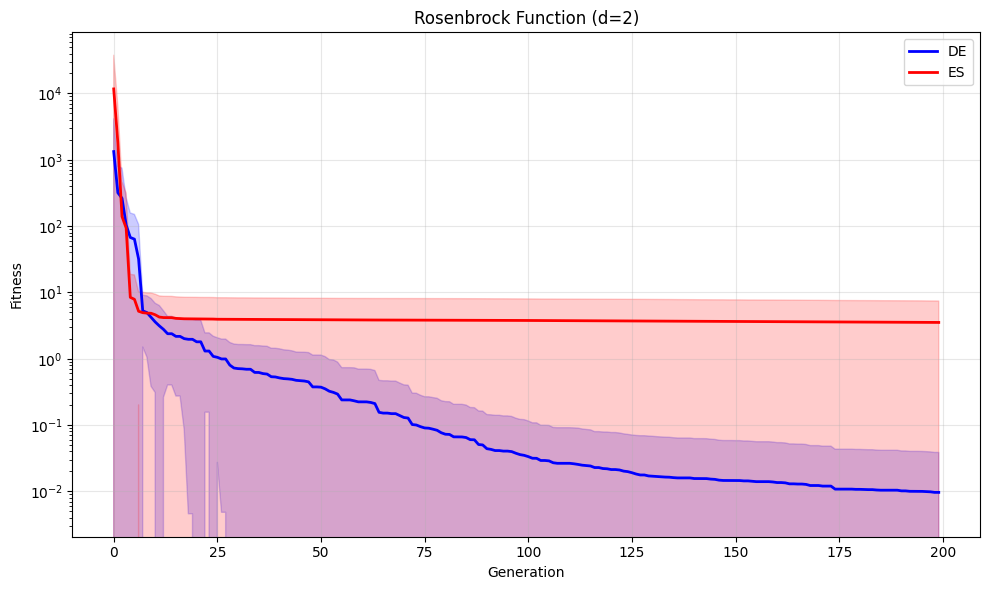

Running...


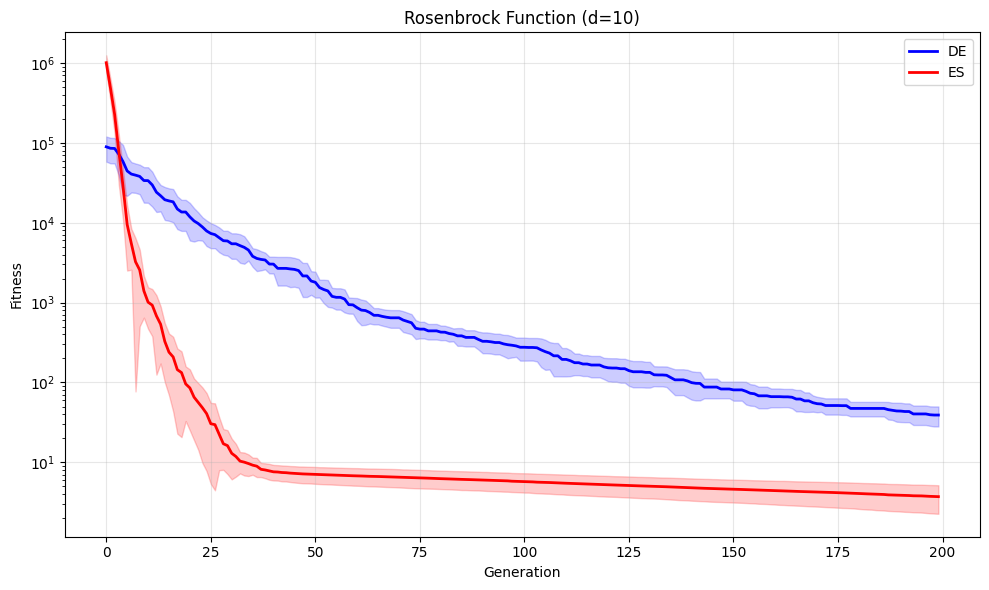

Running...


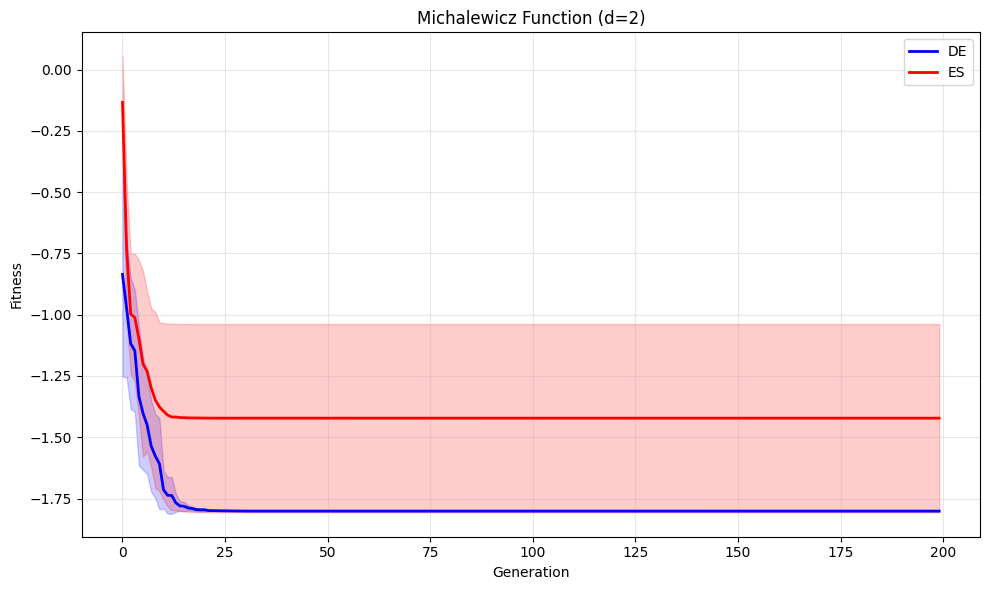

Running...


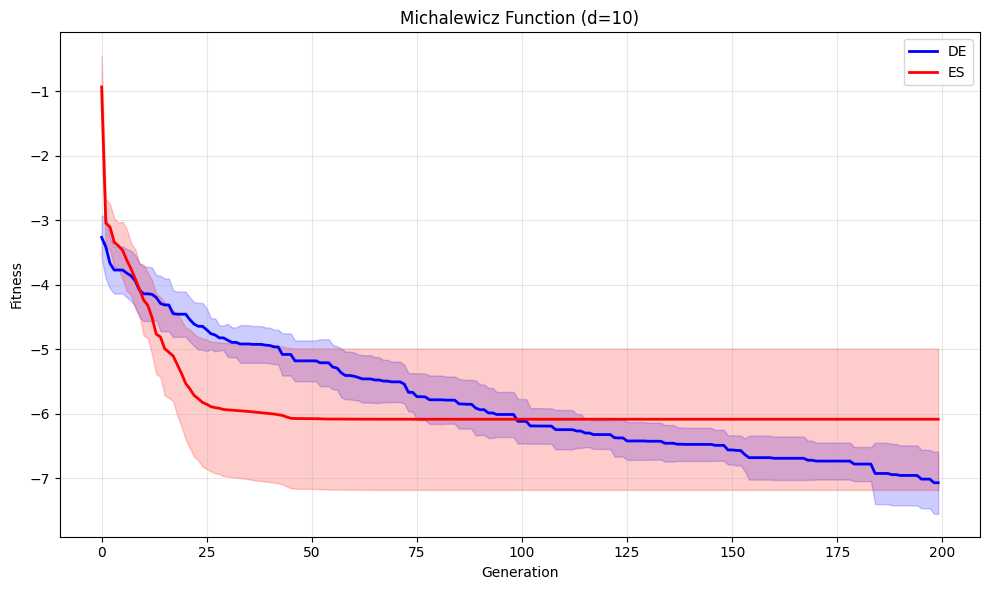


FINAL COMPARISON TABLE
Function     Dim  DE Mean      DE Std       ES Mean      ES Std       Winner  
----------------------------------------------------------------------
sphere       2    0.0000000    0.0000000    0.0000000    0.0000000    ES      
sphere       10   0.0048083    0.0016072    0.0000000    0.0000000    ES      
ackley       2    0.0000000    0.0000000    11.0895776   9.2792435    DE      
ackley       10   1.8339723    0.2817661    19.4029335   0.2238898    DE      
griewank     2    0.0081356    0.0045518    38.4789432   33.1902011   DE      
griewank     10   0.7245305    0.1185631    0.1875709    0.1518852    ES      
rosenbrock   2    0.0096635    0.0289904    3.5280644    3.9019087    DE      
rosenbrock   10   39.1396748   10.9914830   3.7234348    1.4516625    ES      
michalewicz  2    -1.8013034   0.0000000    -1.4220577   0.3840482    DE      
michalewicz  10   -7.0682080   0.4814535    -6.0838962   1.0954206    DE      


In [300]:
# Run ALL experiments efficiently
all_results = run_all_experiments()

### Nhận xét

**Quan sát:**
- **Hàm Sphere**: cả 2 thuật toán đều có khả năng tìm ra lời giải tối ưu, tuy nhiên SE tốt hơn so với DE trên hàm mục tiêu này. Lý do là với hàm Sphere có dạng lồi và trơn, chỉ có 1 cực tiều toàn cục, tất cả các gradient đều hướng về 0, do đó DE không có lợi thế về tính đa dạng. Trong khi đó SE với hàm mục tiêu đơn giản như thế này cùng với hệ số sigma tăng khi tìm được giải pháp tốt hơn, hoạt động tương tự như gradient descent, cho phép khai thác vùng lân cận nghiệm tốt hơn.
- **Hàm Ackley**: DE vượt trội rõ rệt so với ES trên cả dim=2 và dim=10. Ackley là hàm bẫy có rất nhiều cực tiểu cục bộ. Đối với hàm này, tính đa dạng của DE giúp nó có khả năng duy trì tính đa dạng quần thể tốt hơn, tránh bị kẹt ở bẫy cục bộ. Ngược lại ES sinh mẫu tập trung quanh một điểm trung tâm, do đó rất dễ lọt vào bẫy cục bộ.
- **Hàm Griewank**: ở dim=2, DE hoạt động tốt hơn nhờ khai thác tốt tính đa dạng. Tuy nhiên ở dim=10, DE gặp khó khăn do không gian tìm kiếm lớn, các vector khác biệt toả ra nhiều hướng gây nhiễu, còn ES nhờ quá trình điều chỉnh tự động sigma, cho phép khai thác cục bộ tốt hơn.
- **Hàm Rosenbrock**: ở dim=2, DE cho kết quả tốt hơn do có khả năng di chuyển linh hoạt trong thung lũng của hàm, tránh dao động quanh vùng phẳng. Trong khi đó, ES sinh mẫu xung quanh một vùng trung tâm, do đó khó bẻ hướng theo đường cong của hàm. Tuy nhiên, ở không gian cao hơn, DE kém ổn định hơn nhiều do các vector khác biệt có xu hướng toả ra nhiều hướng, giảm hiệu quả tìm kiếm. Trong khi đó ES duy trì sự ổn định nhờ cơ chế tự điều chỉnh sigma.
- **Hàm Michalewicz**: tương tự như hàm Ackley, đây là hàm bẫy có nhiều cực tiểu cục bộ, do đó DE với ưu điểm về tính đa dạng dễ dàng vượt trội SE.

**Tổng kết:**
DE thể hiện ưu thế trên các hàm bẫy có nhiều cực tiểu cục bộ nhờ khả năng duy trì tính đa dạng và khám phá, trong khi SE lại ổn định hơn trên các hàm trơn, đơn cực tiểu. Nhìn chung, DE mạnh về khám phá toàn cục, SE mạnh về khai thác cục bộ.